# IMPORTS

Por incompatibilidades entre librerias nos vemos obligados a hacer este workaround para que solucionar los problemas de dependencias.

In [7]:
import  scipy.signal.signaltools
import numpy as np

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered
import pandas as pd
import matplotlib.pyplot as plt
# import os
# import pickle
import pytorch_forecasting
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
import torch
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss, MAPE
from lightning.pytorch.tuner import Tuner
from  scipy.signal.signaltools import _centered
# from tft_helper import (
#     get_best_lr,
#     tft_trainer,
#     tft_predict,
#     run_hyperparameter_optimization,
#     buildLaggedFeatures,
#     make_preds,
#     add_sma,
#     add_ema,
#     add_rsi,
#     add_macd,
#     add_bollinger_bands
# )

from tft_helper import *

c:\Users\nvegamun\AppData\Local\anaconda3\envs\tft\lib\site-packages\pytorch_forecasting\models\base_model.py:30: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [121]:

import pandas as pd
import os
import sys
basepath = os.path.abspath('') # script directory

sys.path.insert(1, os.path.join(basepath, "..\\"))
from datetime import datetime, timedelta


# PARAMS

In [122]:
seq_len = 1 #sequence lenght: how many timesteps does a sequence have
pred_len = 1 # prediction lenght: how many timesteps does a prediction sequence have
n_prev_len = seq_len *  25 # number of previous timesteps to take for inference
n_preds = 10 # number of predictions with test data
test_len = pred_len * n_preds  # number of timesteps to use for test data
group = 'month'
n_lags = seq_len * pred_len  # number of lags to use
loss = MAPE()
# raw_df_agg = "Timestamp_hour"  # Timestamp_minutes
epochs = 100


lr_finder = False
grid_search = False

# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
# logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard


# TFT params
# tft_params =  {'gradient_clip_val': 0.05808054277495504, 'hidden_size': 32, 'dropout': 0.2997107370422699, 'hidden_continuous_size': 19, 'attention_head_size': 2, 'learning_rate': 0.017853144294677083}
# tft_params =  {'gradient_clip_val': 0.01, 'hidden_size': 36, 'dropout': 0.3, 'hidden_continuous_size': 22, 'attention_head_size': 4, 'learning_rate': 0.001}
# tft_params = {'gradient_clip_val': 0.35, 'hidden_size': 8, 'dropout': 0.1, 'hidden_continuous_size': 8, 'attention_head_size': 4, 'learning_rate': 0.01}
tft_params =  {'gradient_clip_val': 0.03, 'hidden_size': 24, 'dropout': 0.25, 'hidden_continuous_size': 24, 'attention_head_size': 4, 'learning_rate': 0.01, 'loss': loss}


hyperparams_grid = {
    "gradient_clip_val_range": (0.01, 1.0),
    "hidden_size_range": (8, 64),
    "hidden_continuous_size_range": (8, 64),
    "attention_head_size_range": (1, 4),
    "learning_rate_range": (0.001, 0.3),
    "dropout_range": (0.1, 0.3),
    "trainer_kwargs": dict(limit_train_batches=60),
    "reduce_on_plateau_patience": 4,
    "use_learning_rate_finder": False
}

va bien:
tft_params =  {'gradient_clip_val': 0.03, 'hidden_size': 24, 'dropout': 0.25, 'hidden_continuous_size': 24, 'attention_head_size': 4, 'learning_rate': 0.01, group: 'month', n_prev_hours: 10*7, lags: {'target': list(range(1,11))}}

    

# LOAD DATA

In [123]:
import pandas as pd

# Cargar el dataset
file_path = "./data/Datos históricos del IBEX 35.csv"
df = pd.read_csv(file_path)
df = df[::-1].reset_index(drop=True)
df["Fecha"] = pd.to_datetime(df["Fecha"], format="%d.%m.%Y")

# Aplicar las transformaciones
df["Último"] = clean_numeric_column(df["Último"])
df["Apertura"] = clean_numeric_column(df["Apertura"])
df["Máximo"] = clean_numeric_column(df["Máximo"])
df["Mínimo"] = clean_numeric_column(df["Mínimo"])
df["Vol."] = clean_volume_column(df["Vol."])
df["% var."] = clean_percentage_column(df["% var."])

# Eliminar la columna 'Fecha'
df = df.rename(
    columns={
        "Fecha": "fechaHora",
        "Vol.": "vol",
        "% var.": "var",
        "Último": "target",
        "Máximo": "max",
        "Mínimo": "min",
        "Apertura": "open",
    }
)
# df = df.iloc[::-1]
df = df.reset_index(drop=True)
# df = df[:-1]
# Guardar el dataframe limpio en un nuevo archivo CSV
# df_numeric.to_csv('ruta/a/tu/archivo/ibex35_cleaned.csv', index=False)

## ADD INDICATORS


In [124]:
lags = buildLaggedFeatures(df, n_lags, ["target"])
df = pd.concat([df, lags], axis=1)
periods = [5, 10, 15, 20]

# Supongamos que df es tu DataFrame
for i in periods:
    df = add_sma(df, period=i)
    df = add_ema(df, period=i)
for i in [6, 10, 14]:
    df = add_rsi(df, period=i)
for i in periods:
    df = add_bollinger_bands(df, period=i)
df = add_macd(df)

for i in periods:
    df = add_atr(df, period=i)

# Agregar CCI con diferentes períodos
for i in periods:
    df = add_cci(df, period=i)

# Agregar ROC con diferentes períodos
for i in [10, 14, 20, 50]:
    df = add_roc(df, period=i)

# Agregar Stochastic Oscillator con diferentes períodos
for i in [10, 14, 20, 25, 50]:
    df = add_stochastic(df, period=i)

# Agregar Williams %R con diferentes períodos
for i in [10, 14]:
    df = add_williams_r(df, period=i)

df = add_atr(df)

# Agregar Parabolic SAR (sin período, pero podrías ajustar los factores de aceleración)
# data = add_parabolic_sar(data)

# Agregar Ichimoku Cloud (no requiere período)
# df = add_ichimoku(df)

# Calculate ATR (Average True Range)

# df['ATR'] = ta.ATR(df['max'], df['min'], df['close'], timeperiod=14)

# Calculate ADX (Average Directional Index)
# df['ADX'] = ta.ADX(df['max'], df['min'], df['close'], timeperiod=14)


# # Calculate CCI (Commodity Channel Index)
# df['CCI'] = ta.CCI(df['max'], df['min'], df['close'], timeperiod=14)

# # Calculate OBV (On-Balance Volume)
# df['OBV'] = ta.OBV(df['close'], df['vol'])

# # Calculate Stochastic Oscillator (SlowK, SlowD)
# df['SlowK'], df['SlowD'] = ta.STOCH(df['max'], df['min'], df['close'], fastk_period=14, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)

# df['WilliamsR'] = ta.WILLR(df['max'], df['min'], df['close'], timeperiod=14)


In [34]:
# import pandas as pd
# import numpy as np

# num_filas = 2000

# ## Fechas para ambas series
# fechas = pd.date_range(start="2024-08-01", periods=num_filas, freq="D")

# # Generar valores aleatorios para 'target'
# targets = np.random.randint(0, 100, size=num_filas)

# # Crear el primer DataFrame (df1)
# df1 = pd.DataFrame({"fechaHora": fechas, "target": targets})

# # Crear el segundo DataFrame (df2) idéntico al primero
# df2 = df1.copy()

# # Modificar la última fila del segundo DataFrame (df2)
# df2.at[num_filas - 1, "target"] = np.random.randint(
#     0, 1000
# )  # Un valor en un rango diferente para diferenciar

# periods = [5, 10, 15, 20]

# # Supongamos que df es tu DataFrame
# for i in periods:
#     df1 = add_sma(df1, period=i)
#     df1 = add_ema(df1, period=i)
# for i in [6, 10, 14]:
#     df1 = add_rsi(df1, period=i)
# for i in periods:
#     df1 = add_bollinger_bands(df1, period=i)
# df1 = add_macd(df1)

# for i in periods:
#     df1 = add_atr(df1, period=i)

# # Agregar CCI con diferentes períodos
# for i in periods:
#     df1 = add_cci(df1, period=i)

# # Agregar ROC con diferentes períodos
# for i in [10, 14, 20, 50]:
#     df1 = add_roc(df1, period=i)

# # Agregar Stochastic Oscillator con diferentes períodos
# for i in [10, 14, 20, 25, 50]:
#     df1 = add_stochastic(df1, period=i)

# # Agregar Williams %R con diferentes períodos
# for i in [10, 14]:
#     df1= add_williams_r(df1, period=i)

# periods = [5, 10, 15, 20]

# # Supongamos que df es tu DataFrame
# for i in periods:
#     df2 = add_sma(df2, period=i)
#     df2 = add_ema(df2, period=i)
# for i in [6, 10, 14]:
#     df2 = add_rsi(df2, period=i)
# for i in periods:
#     df2= add_bollinger_bands(df2, period=i)
# df2 = add_macd(df2)

# for i in periods:
#     df2 = add_atr(df2, period=i)

# # Agregar CCI con diferentes períodos
# for i in periods:
#     df2 = add_cci(df2, period=i)

# # Agregar ROC con diferentes períodos
# for i in [10, 14, 20, 50]:
#     df2 = add_roc(df2, period=i)

# # Agregar Stochastic Oscillator con diferentes períodos
# for i in [10, 14, 20, 25, 50]:
#     df2 = add_stochastic(df2, period=i)

# # Agregar Williams %R con diferentes períodos
# for i in [10, 14]:
#     df2 = add_williams_r(df2, period=i)

# cols_to_shift = df1.columns[2:]
# # Desplazar los valores en las columnas seleccionadas
# df1[cols_to_shift] = df1[cols_to_shift].shift(1)
# df2[cols_to_shift] = df2[cols_to_shift].shift(1)

# df1.dropna() == df2.dropna()

In [125]:
cols_to_shift = df.columns[2:]
# Desplazar los valores en las columnas seleccionadas
df[cols_to_shift] = df[cols_to_shift].shift(1)
df

,fechaHora,target,open,max,min,vol,var,target_lag1,SMA_5,EMA_5,...,Stochastic_14_K,Stochastic_14_D,Stochastic_20_K,Stochastic_20_D,Stochastic_25_K,Stochastic_25_D,Stochastic_50_K,Stochastic_50_D,Williams_%R_10,Williams_%R_14
0,2021-01-04,8099.2,8191.8,8207.2,8053.0,213150000.0,0.32,NaN,NaN,8099.200000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-05,8091.5,8052.2,8118.1,8037.4,173800000.0,-0.10,8099.2,NaN,8096.633333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-06,8350.3,8179.8,8383.7,8134.1,275700000.0,3.20,8091.5,NaN,8181.188889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-07,8385.8,8383.8,8399.5,8274.1,247340000.0,0.43,8350.3,NaN,8249.392593,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-08,8407.7,8439.7,8439.7,8366.2,204980000.0,0.26,8385.8,8266.90,8302.161728,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,2024-08-20,11087.8,11130.5,11151.9,11056.5,68430000.0,-0.13,11102.5,10955.72,10971.894236,...,100.000000,76.607971,86.596935,71.608692,86.596935,70.724219,82.781072,63.144843,-0.000000,-0.000000
934,2024-08-21,11114.9,11080.8,11127.2,11066.3,66680000.0,0.24,11087.8,11028.10,11019.562824,...,97.935393,88.931303,85.078087,79.895890,84.809049,79.806211,81.071968,73.899774,-2.699725,-2.064607
935,2024-08-22,11156.3,11110.4,11207.5,11107.4,73240000.0,0.37,11114.9,11082.24,11065.141883,...,100.000000,99.311798,89.200837,86.958620,88.105084,86.503689,84.222765,82.691935,-0.000000,-0.000000
936,2024-08-23,11278.1,11183.0,11285.2,11178.7,76130000.0,1.09,11156.3,11147.92,11136.127922,...,100.000000,99.311798,94.298732,89.525885,93.140355,88.684829,89.036159,84.776964,-0.000000,-0.000000


In [126]:
data = df.copy()
data["month"] = 1
data["week"] = (
    data["fechaHora"].dt.strftime("%Y-%U").astype(str).astype("category").cat.codes
)
# data['day'] = data['fechaHora'].dt.day.astype('category').cat.codes

data["day"] = (data["fechaHora"] - data["fechaHora"].min()).dt.days
# data["hour"] = data["fechaHora"].dt.hour

# data['time_idx'] = data.groupby(group).cumcount()

data["time_idx"] = data.index

# data['Low'].fillna(method='ffill', inplace=True)
# data['High'].fillna(method='ffill', inplace=True)


In [127]:
full = data.copy()

data = full[:-test_len]
test = full[-test_len:]
# test['target'] = 0
data = data.reset_index(drop=True)
data = data.dropna()

In [128]:
data.columns

Index(['fechaHora', 'target', 'open', 'max', 'min', 'vol', 'var',
       'target_lag1', 'SMA_5', 'EMA_5', 'SMA_10', 'EMA_10', 'SMA_15', 'EMA_15',
       'SMA_20', 'EMA_20', 'RSI_6', 'RSI_10', 'RSI_14', 'Bollinger_Upper_5',
       'Bollinger_Lower_5', 'Bollinger_Upper_10', 'Bollinger_Lower_10',
       'Bollinger_Upper_15', 'Bollinger_Lower_15', 'Bollinger_Upper_20',
       'Bollinger_Lower_20', 'MACD', 'Signal_Line', 'ATR_5', 'ATR_10',
       'ATR_15', 'ATR_20', 'CCI_5', 'CCI_10', 'CCI_15', 'CCI_20', 'ROC_10',
       'ROC_14', 'ROC_20', 'ROC_50', 'Stochastic_10_K', 'Stochastic_10_D',
       'Stochastic_14_K', 'Stochastic_14_D', 'Stochastic_20_K',
       'Stochastic_20_D', 'Stochastic_25_K', 'Stochastic_25_D',
       'Stochastic_50_K', 'Stochastic_50_D', 'Williams_%R_10',
       'Williams_%R_14', 'month', 'week', 'day', 'time_idx'],
      dtype='object')

<!-- ## DF FINL -->

## TimeSeriesDataset

In [129]:
features = [col for col in data.columns if col != 'target' ]  # Columnas de características and col != 'fechaHora'

max_prediction_length = pred_len
max_encoder_length = n_prev_len #48
# training_cutoff = data["fechaHora"].max() - pd.Timedelta(hours=max_encoder_length)
training_cutoff = data["time_idx"].max() - max_prediction_length


train = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="target",
    group_ids=[group],
    min_encoder_length=max_encoder_length,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    # min_prediction_length=24,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=[],  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["fechaHora", "month", "week", "day", "time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "target",
        "open",
        "max",
        "min",
        "vol",
        "var",
        "SMA_5",
        "EMA_5",
        "SMA_10",
        "EMA_10",
        "SMA_15",
        "EMA_15",
        "SMA_20",
        "EMA_20",
        "RSI_6",
        "RSI_10",
        "RSI_14",
        "Bollinger_Upper_5",
        "Bollinger_Lower_5",
        "Bollinger_Upper_10",
        "Bollinger_Lower_10",
        "Bollinger_Upper_15",
        "Bollinger_Lower_15",
        "Bollinger_Upper_20",
        "Bollinger_Lower_20",
        "MACD",
        "Signal_Line",
        "ATR_5",
        "ATR_10",
        "ATR_15",
        "ATR_20",
        "CCI_5",
        "CCI_10",
        "CCI_15",
        "CCI_20",
        "ROC_10",
        "ROC_14",
        "ROC_20",
        "ROC_50",
        "Stochastic_10_K",
        "Stochastic_10_D",
        "Stochastic_14_K",
        "Stochastic_14_D",
        "Stochastic_20_K",
        "Stochastic_20_D",
        "Stochastic_25_K",
        "Stochastic_25_D",
        "Stochastic_50_K",
        "Stochastic_50_D",
        "Williams_%R_10",
        "Williams_%R_14",
    ],
    # lags={"target": list(range(1, 5))},
    # target_normalizer=GroupNormalizer("standard", groups=[group], transformation="softplus"),
    # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    allow_missing_timesteps=True,
    # add_encoder_length=True,
    # categorical_encoders={
    #     "month": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
    #     "week": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
    #     "day": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
    # },
)

validation = TimeSeriesDataSet.from_dataset(train, data, predict=True, stop_randomization=True)
# test = TimeSeriesDataSet.from_dataset(training, test_data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 64  # set this between 32 to 128
train_dataloader = train.to_dataloader(train=True, batch_size=batch_size, num_workers=7, persistent_workers=True)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=7, persistent_workers=True)
# test_dataloader = test.to_dataloader(train=False, batch_size=batch_size, num_workers=11, persistent_workers=True)

In [130]:
validation

TimeSeriesDataSet[length=1](
	time_idx='time_idx',
	target='target',
	group_ids=['month'],
	weight=None,
	max_encoder_length=25,
	min_encoder_length=25,
	min_prediction_idx=52,
	min_prediction_length=1,
	max_prediction_length=1,
	static_categoricals=[],
	static_reals=['target_center', 'target_scale'],
	time_varying_known_categoricals=[],
	time_varying_known_reals=['fechaHora', 'month', 'week', 'day', 'time_idx', 'relative_time_idx'],
	time_varying_unknown_categoricals=[],
	time_varying_unknown_reals=['target', 'open', 'max', 'min', 'vol', 'var', 'SMA_5', 'EMA_5', 'SMA_10', 'EMA_10', 'SMA_15', 'EMA_15', 'SMA_20', 'EMA_20', 'RSI_6', 'RSI_10', 'RSI_14', 'Bollinger_Upper_5', 'Bollinger_Lower_5', 'Bollinger_Upper_10', 'Bollinger_Lower_10', 'Bollinger_Upper_15', 'Bollinger_Lower_15', 'Bollinger_Upper_20', 'Bollinger_Lower_20', 'MACD', 'Signal_Line', 'ATR_5', 'ATR_10', 'ATR_15', 'ATR_20', 'CCI_5', 'CCI_10', 'CCI_15', 'CCI_20', 'ROC_10', 'ROC_14', 'ROC_20', 'ROC_50', 'Stochastic_10_K', 'Stocha


# LEARNIG RATE FINDER

En primer lugar realizamos un estudio para hallar de forma aproximada el valor optimo de tasa de aprendizaje.  No es recomendable al 100% usar el valor sugerido directamente pues a veces no encuentra el mejor, sin embargo si que da un muy buen punto de partida por donde empezar a probar. Para ello usamos un modelo TFT cualquiera basico.

In [131]:
if lr_finder:
    res = get_best_lr(train, train_dataloader, val_dataloader, **tft_params)


# MODELLING

## TRAIN MODEL

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\nvegamun\AppData\Local\anaconda3\envs\tft\lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\nvegamun\AppData\Local\anaconda3\envs\tft\lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | MAPE                            | 0      | train
1  | loggin

c:\Users\nvegamun\AppData\Local\anaconda3\envs\tft\lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 50: 100%|██████████| 13/13 [00:06<00:00,  1.97it/s, v_num=245, train_loss_step=0.00761, val_loss=0.0068, train_loss_epoch=0.00844] Number of parameters in network: 230.5k


c:\Users\nvegamun\AppData\Local\anaconda3\envs\tft\lib\site-packages\lightning\pytorch\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


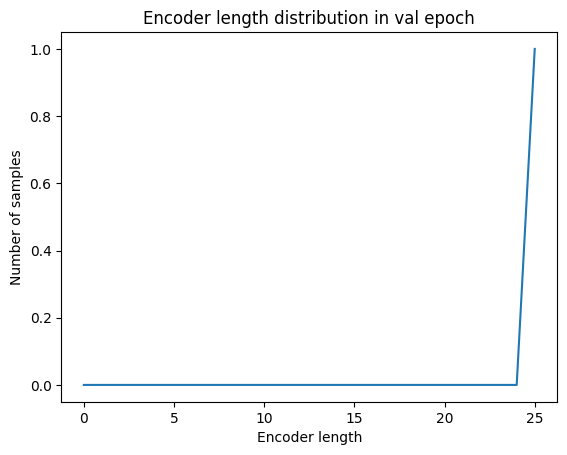

In [132]:
if not grid_search:
    # tft_params['learning_rate'] = 0.01
    tft, val_loss = tft_trainer(train, train_dataloader, val_dataloader, max_epochs=epochs, **tft_params)

### EVAL MODEL

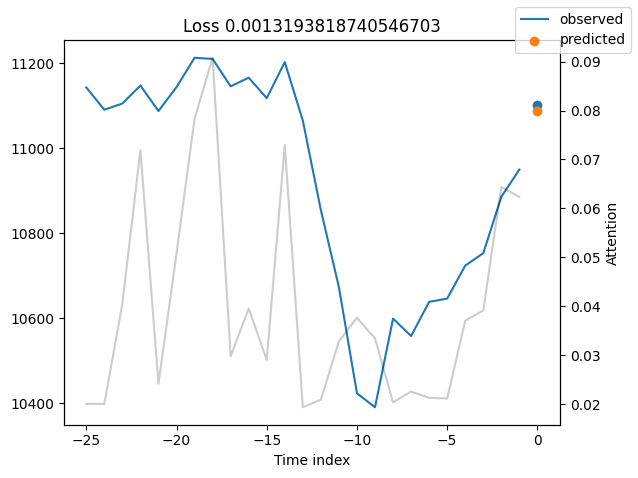

In [ ]:
if not grid_search:
    preds = tft_predict(tft, val_dataloader)


## GRID SEARCH

In [ ]:
# from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# study = optimize_hyperparameters(
#     train_dataloader,
#     val_dataloader,
#     model_path="optuna_test",
#     n_trials=2,
#     max_epochs=2,
#     gradient_clip_val_range=(0.01, 1.0),
#     hidden_size_range=(8, 128),
#     hidden_continuous_size_range=(8, 128),
#     attention_head_size_range=(1, 4),
#     learning_rate_range=(0.001, 0.1),
#     dropout_range=(0.1, 0.3),
#     trainer_kwargs=dict(limit_train_batches=30),
#     reduce_on_plateau_patience=4,
#     use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
# )
# print(f"Mejores hiperparámetros hallados: {study.best_trial.params}")
# best_hyperparameters = study.best_trial.params


In [ ]:
if grid_search:
    study, best_tft = run_hyperparameter_optimization(train, train_dataloader, val_dataloader, n_trials=1, max_epochs=2, **hyperparams_grid)
    print(study.best_trial.params)

Podemos cortar la ejecucion y reanudarla posteriormente si habilitamos las siguientes lineas.

### EVAL BEST FOUND MODEL

In [ ]:
if grid_search:
    tft_predict(best_tft, val_dataloader, n_preds=1)


# TEST EVAL

In [ ]:
def make_preds_it(
    train,
    test,
    model,
    encoder_lenght,
    test_lenght,
    pred_lenght,
    quantiles: bool = True,
):
    # group = model.output_transformer.groups[0]
    if quantiles:
        try:  # for Quantileloss
            preds = []
            preds_data = pd.concat([train[-encoder_lenght:], test])
            for i in range(0, test_lenght, pred_lenght):
                new_data = preds_data[i : i + encoder_lenght + pred_lenght]
                new_data.loc[:, group] = new_data.iloc[0, new_data.columns.get_loc(group)]
                new_raw_predictions = model.predict(new_data, mode="raw", return_x=True)
                prediction = []
                for i in range(pred_lenght):
                    prediction.append(float(new_raw_predictions.output.prediction[0][i][3]))
                preds.append(prediction)
        except:  # for MQF2DistributionLoss
            preds = []
            preds_data = pd.concat([train[-encoder_lenght:], test])
            for i in range(0, test_lenght, pred_lenght):
                new_data = preds_data[i : i + encoder_lenght + pred_lenght]
                new_data.loc[:, group] = new_data.iloc[0, new_data.columns.get_loc(group)]
                prediction = model.to_prediction(new_raw_predictions.output)[0].flatten().tolist()
                preds.append(prediction)
    else:
        preds = []
        preds_data = pd.concat([train[-encoder_lenght:], test])
        for i in range(0, test_lenght, pred_lenght):
            new_data = preds_data[i : i + encoder_lenght + pred_lenght]
            new_data.loc[:, group] = new_data.iloc[0, new_data.columns.get_loc(group)]
            new_raw_predictions = model.predict(new_data, mode="raw", return_x=True)
            prediction = new_raw_predictions.output.prediction[0].flatten().tolist()
            # preds_data.loc[i + encoder_lenght + pred_lenght + 1, 'target'] = prediction
            preds.append(prediction)

    return preds

In [ ]:
preds = []
preds_data = pd.concat([data[-n_prev_len:], test])
# preds_data = preds_data.ffill()
# preds_data["target"] = float(1)
# preds_data.drop(columns=['target'], inplace=True)
for i in range(0, test_len, pred_len):
    new_data = preds_data[i : i + n_prev_len + pred_len]
    new_data.loc[:, group] = new_data.iloc[0, new_data.columns.get_loc(group)]
    # print(i,i + n_prev_len + pred_len)
    new_raw_predictions = tft.predict(new_data, mode="raw", return_x=True)
    prediction = int(new_raw_predictions.output.prediction[0])
    #------- HAY QUE CONFIRMAR QUE LA PREDICCION SE INTRODUZCA EN ESA FILA. (AL PRINCIPIO HICIMOS SHIFT)
    preds_data.loc[preds_data.index[i + n_prev_len + pred_len-1], "target"] = int(prediction)
# ---------------- FALTA RECALCULAR INDICADORES A PARTIR DEL NUEVO VALOR. ---------------
    preds.append(prediction)

c:\Users\nvegamun\AppData\Local\anaconda3\envs\tft\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nvegamun\AppData\Local\anaconda3\envs\tft\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\nvegamun\AppData\Local\anaconda3\envs\tft\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\nvegamun\AppData\Local\anaconda3\envs\tft\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_worker

In [ ]:
preds

[11227, 11236, 11283, 11364, 11499]

In [ ]:
# preds = make_preds_it(
#     train=data,
#     test=test,
#     model=tft,
#     encoder_lenght=n_prev_len,
#     test_lenght=test_len,
#     pred_lenght=pred_len,
#     quantiles=True if isinstance(loss, QuantileLoss) else False,
# )

MAE: 141.28000000000029
MAPE: 0.012629993013696028
RMSE: 149.66348920160883


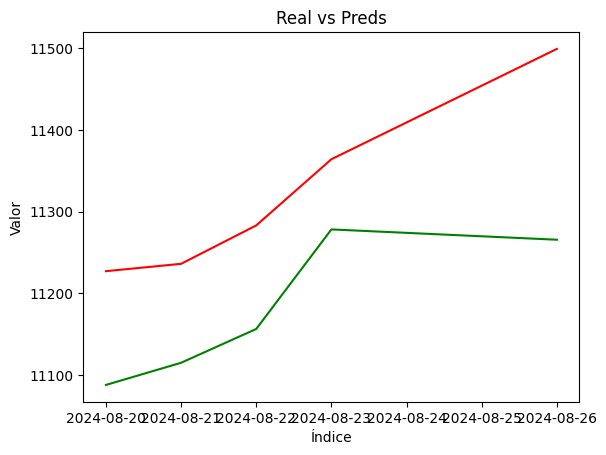

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error

dates = test["fechaHora"].to_list()
preds_flat = preds #[item for sublist in preds for item in sublist]

# real_vals = list(data[-n_preds * pred_len :]["target"])
real_vals = test['target'].to_list()

print(f"MAE: {mean_absolute_error(real_vals, preds_flat)}")
print(f"MAPE: {mean_absolute_percentage_error(real_vals, preds_flat)}")
print(f"RMSE: {root_mean_squared_error(real_vals, preds_flat)}")

plt.plot(dates, preds_flat, color="r")
plt.plot(dates, real_vals, color="g")
plt.title("Real vs Preds")
plt.xlabel("Índice")
plt.ylabel("Valor")
plt.show()

MAE: 141.28000000000029
MAPE: 0.012629993013696028
RMSE: 149.66348920160883


c:\Users\nvegamun\AppData\Local\anaconda3\envs\tft\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


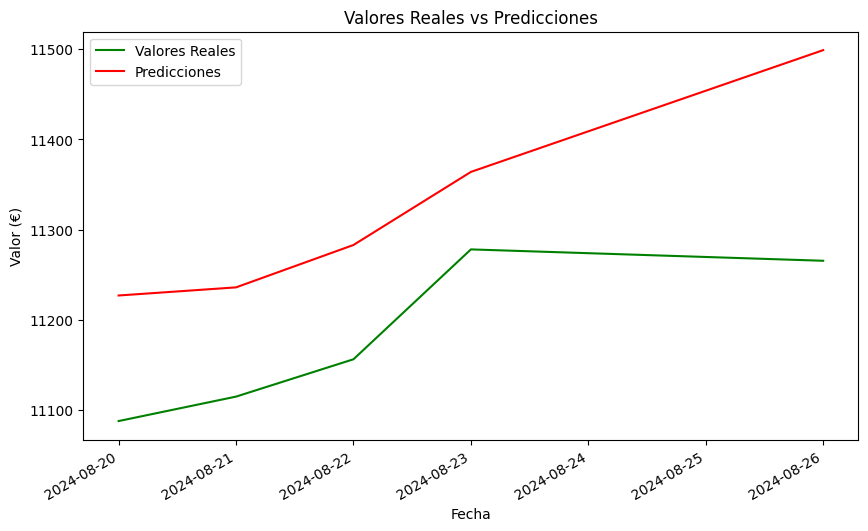

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import matplotlib.dates as mdates

# Convertir las fechas a formato de datetime si no están ya
dates = pd.to_datetime(test["fechaHora"]).to_list()

# Aplanar las predicciones si es necesario
preds_flat = preds

# Valores reales
real_vals = test["target"].to_list()

# Métricas de error
print(f"MAE: {mean_absolute_error(real_vals, preds_flat)}")
print(f"MAPE: {mean_absolute_percentage_error(real_vals, preds_flat)}")
print(f"RMSE: {mean_squared_error(real_vals, preds_flat, squared=False)}")

# Gráfico
plt.figure(figsize=(10, 6))
plt.plot(dates, real_vals, color="g", label="Valores Reales")
plt.plot(dates, preds_flat, color="r", label="Predicciones")
plt.title("Valores Reales vs Predicciones")
plt.xlabel("Fecha")
plt.ylabel("Valor (€)")

# Formato de fecha en el eje x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()  # Rotar fechas para mejor visualización

# Añadir leyenda
plt.legend()

# Mostrar gráfico
plt.show()

MAE: 141.28000000000029
MAPE: 0.012629993013696028
RMSE: 149.66348920160883


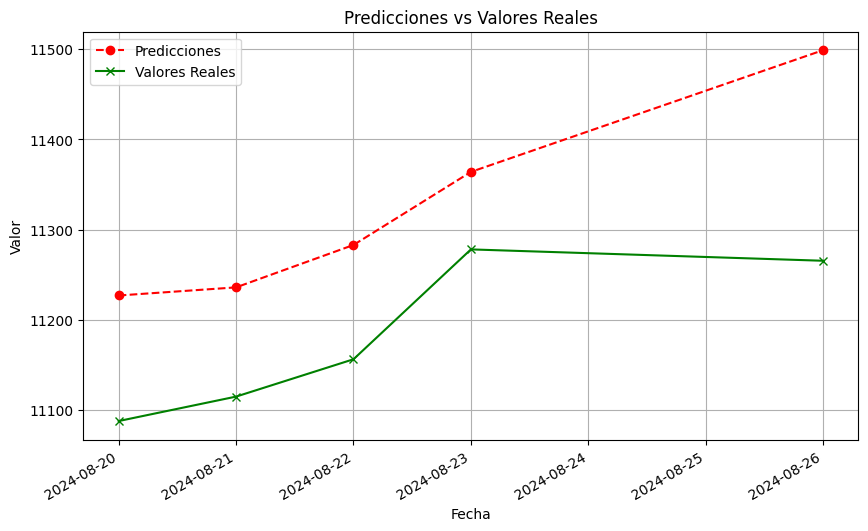

In [ ]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Supongamos que `preds`, `test`, y `dates` ya están definidos en tu entorno

# Aplanar la lista de predicciones
preds_flat = preds

# Convertir los valores reales a una lista
real_vals = test["target"].to_list()

# Lista de fechas (timestamps)


# Calcular el error absoluto medio
print(f"MAE: {mean_absolute_error(real_vals, preds_flat)}")
print(f"MAPE: {mean_absolute_percentage_error(real_vals, preds_flat)}")
print(f"RMSE: {root_mean_squared_error(real_vals, preds_flat)}")
# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(dates, preds_flat, color="r", label="Predicciones", marker="o", linestyle="--")
plt.plot(dates, real_vals, color="g", label="Valores Reales", marker="x", linestyle="-")

# Añadir título y etiquetas
plt.title("Predicciones vs Valores Reales")
plt.xlabel("Fecha")
plt.ylabel("Valor")

# Formatear las fechas en el eje x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
# plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))
plt.gcf().autofmt_xdate()  # Rotar las etiquetas de fecha

# Añadir cuadrícula y leyenda
plt.grid(True)
plt.legend()
# 
# Mostrar la gráfica
plt.show()

# INFERENCE

## Retrain for inference

In [ ]:
features = [
    col for col in data.columns if col != "target"
]  # Columnas de características and col != 'fechaHora'

max_prediction_length = pred_len
max_encoder_length = n_prev_len  # 48
# training_cutoff = data["fechaHora"].max() - pd.Timedelta(hours=max_encoder_length)
training_cutoff = data["time_idx"].max() - max_prediction_length

retrain = TimeSeriesDataSet(
    full.dropna()[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="target",
    group_ids=[group],
    min_encoder_length=max_encoder_length,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    # min_prediction_length=24,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=[],  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["fechaHora", "month", "week", "day", "time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "target",
        "open",
        "max",
        "min",
        "vol",
        "var",
        "SMA_5",
        "EMA_5",
        "SMA_10",
        "EMA_10",
        "SMA_15",
        "EMA_15",
        "SMA_20",
        "EMA_20",
        "RSI_6",
        "RSI_10",
        "RSI_14",
        "Bollinger_Upper_5",
        "Bollinger_Lower_5",
        "Bollinger_Upper_10",
        "Bollinger_Lower_10",
        "Bollinger_Upper_15",
        "Bollinger_Lower_15",
        "Bollinger_Upper_20",
        "Bollinger_Lower_20",
        "MACD",
        "Signal_Line",
        "ATR_5",
        "ATR_10",
        "ATR_15",
        "ATR_20",
        "CCI_5",
        "CCI_10",
        "CCI_15",
        "CCI_20",
        "ROC_10",
        "ROC_14",
        "ROC_20",
        "ROC_50",
        "Stochastic_10_K",
        "Stochastic_10_D",
        "Stochastic_14_K",
        "Stochastic_14_D",
        "Stochastic_20_K",
        "Stochastic_20_D",
        "Stochastic_25_K",
        "Stochastic_25_D",
        "Stochastic_50_K",
        "Stochastic_50_D",
        "Williams_%R_10",
        "Williams_%R_14",
    ],
    # lags={"target": list(range(1, 5))},
    # target_normalizer=GroupNormalizer("standard", groups=[group], transformation="softplus"),
    # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    allow_missing_timesteps=True,
    # add_encoder_length=True,
    # categorical_encoders={
    #     "month": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
    #     "week": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
    #     "day": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
    # },
)

revalidation = TimeSeriesDataSet.from_dataset(retrain, full.dropna(), predict=True, stop_randomization=True)

# test = TimeSeriesDataSet.from_dataset(training, test_data, predict=True, stop_randomization=True)


# create dataloaders for model

batch_size = 64  # set this between 32 to 128

retrain_dataloader = retrain.to_dataloader(

    train=True, batch_size=batch_size, num_workers=7, persistent_workers=True

)

reval_dataloader = revalidation.to_dataloader(

    train=False, batch_size=batch_size, num_workers=7, persistent_workers=True

)

# test_dataloader = test.to_dataloader(train=False, batch_size=batch_size, num_workers=11, persistent_workers=True)

if not grid_search:

    # tft_params['learning_rate'] = 0.01

    retft, val_loss = tft_trainer(

        retrain, retrain_dataloader, reval_dataloader, max_epochs=epochs, **tft_params

    )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\nvegamun\AppData\Local\anaconda3\envs\tft\lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\nvegamun\AppData\Local\anaconda3\envs\tft\lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | MAPE                            | 0      | train
1  | loggin

c:\Users\nvegamun\AppData\Local\anaconda3\envs\tft\lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 74: 100%|██████████| 12/12 [00:08<00:00,  1.41it/s, v_num=128, train_loss_step=0.0127, val_loss=0.0332, train_loss_epoch=0.0131]

`Trainer.fit` stopped: `max_epochs=75` reached.


Epoch 74: 100%|██████████| 12/12 [00:08<00:00,  1.36it/s, v_num=128, train_loss_step=0.0127, val_loss=0.0332, train_loss_epoch=0.0131]
Number of parameters in network: 230.5k


In [ ]:
encoder_data = full[-n_prev_len:]
last_row = full.iloc[-1]
# Creamos nuevas filas
new_rows = []
for i in range(1, 6):
    new_row = last_row.copy()
    new_row["fechaHora"] += timedelta(days=i)
    new_row["day"] += i
    new_row["time_idx"] += i
    new_rows.append(new_row)

# Concatenamos las nuevas filas al DataFrame original
decoder_data = pd.DataFrame(new_rows)

new_data = pd.concat([encoder_data, decoder_data], ignore_index=True)
new_data.loc[:, group] = new_data.iloc[0, new_data.columns.get_loc(group)]
# new_data.loc[-pred_len: ,'target'] = 1
new_raw_predictions = retft.predict(new_data, mode="raw", return_x=True)
if isinstance(loss, QuantileLoss):
    prediction = []
    for i in range(pred_len):
        prediction.append(float(new_raw_predictions.output.prediction[0][i][3]))
else:
    prediction = new_raw_predictions.output.prediction[0].flatten().tolist()
prediction

c:\Users\nvegamun\AppData\Local\anaconda3\envs\tft\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\nvegamun\AppData\Local\anaconda3\envs\tft\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\nvegamun\AppData\Local\anaconda3\envs\tft\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[10992.4228515625,
 11006.1220703125,
 11014.8837890625,
 11020.8447265625,
 11025.123046875]

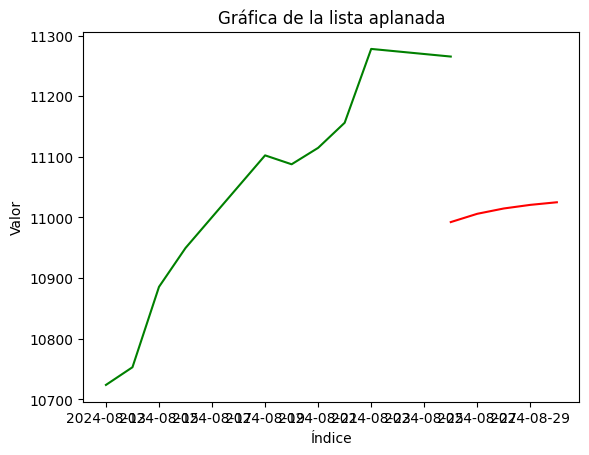

In [ ]:
# prediction = [11233.22265625, 11129.837890625, 11228.3486328125, 11315.59375, 11555.85546875]
last_vals = full[-10:]
last_vals = last_vals[["fechaHora", "target"]]
fechas_azul = pd.date_range(start="2024-08-26", periods=len(prediction))
predictions = pd.DataFrame({"fechaHora": fechas_azul, "target": prediction})

plt.plot(predictions['fechaHora'], predictions['target'], color="r")
plt.plot(last_vals["fechaHora"], last_vals["target"], color="g")
plt.title("Gráfica de la lista aplanada")
plt.xlabel("Índice")
plt.ylabel("Valor")
plt.show()

# INTERPRETABILITY

In [ ]:
interpretation = tft.interpret_output(preds.output, reduction="sum") #
tft.plot_interpretation(interpretation)


AttributeError: 'list' object has no attribute 'output'